# NEG Core-Periphery Model

Based on Chapter 4 from the book _New Introduction to Geographical Economics_ by Brakman et al, we have constructured a simulation that yields the Tomahawk and Wiggle diagrams to illustrate the dynamics between two regions. 

## Importing packages

We start by importing the necessary libraries, which in this case are Pandas, Numpy and Plotnine. We decided to make use of Plotnine as a Python euqivalent of the R library GGplot due to its good diagrams and ease of use. Furthermore, to solve the non linear equations of the simulation from the Scipy.optimize library.

In [1]:
from plotnine import *
from scipy.optimize import fsolve
import numpy as np
import pandas as pd

## Calibrating the parameters.

We set the initial parameters to the desired values to represent the two regions we want to analyse. We also set the simulation parameters to fix when it start and finishes, and the size of each step.

In [2]:
L = 2.0        # Total labor force
phi1 = 0.48    # fraction of food works living in region 1
gam = 0.3      # fraction that works in manufacturing
eps = 5.0      # elasticity of demand
rho = 0.8      # substitution parameter of variety
bet = 0.8      # variable costs
alp = 0.08     # fixed costs
delta = 0.4    # budget share manufacturing


iter_l = 999
step_l = 0.001
start_l = 0.001

iter_th = 51
start_th = 1.5
step_th = 0.01

start = [1, 1, 1, 1, 1, 1]

## Secondary Function

To solve the non-linear equations from the literature, we make use of a separate function that we code. This simplifies the iterations.

In [3]:
def equilibrium(vector_input, phi1, gam, lam, L, rho, bet, delta, alp, eps, T):
    Income_1, Income_2, Wage_Rate_1, W2, I1, I2 = vector_input
    Results = [Income_1 - phi1 * (1 - gam) * L - lam * gam * L * Wage_Rate_1,
               Income_2 - (1 - phi1) * (1 - gam) * L - (1 - lam) * gam * L * W2,
               Wage_Rate_1 - rho * bet ** (-rho) * (delta / (alp * (eps - 1))) ** (1 / eps) *
               (Income_1 * I1 ** (eps - 1) + T ** (1 - eps) * Income_2 * I2 ** (eps - 1)) ** (1 / eps),
               W2 - rho * bet ** (-rho) * (delta / (alp * (eps - 1))) ** (1 / eps) *
               (T ** (1 - eps) * Income_1 * I1 ** (eps - 1) + Income_2 * I2 ** (eps - 1)) ** (1 / eps),
               I1 - (gam * L / (alp * eps)) ** (1 / (1 - eps)) * (bet / rho) *
               (lam * Wage_Rate_1 ** (1 - eps) + (1 - lam) * T ** (1 - eps) * W2 ** (1 - eps)) ** (1 / (1 - eps)),
               I2 - (gam * L / (alp * eps)) ** (1 / (1 - eps)) * (bet / rho) *
               (lam * T ** (1 - eps) * Wage_Rate_1 ** (1 - eps) + (1 - lam) * W2 ** (1 - eps)) ** (1 / (1 - eps))]
    return Results

## Main function

Finally, we start developing the main function. Due to Jupyter's nature, we do not structure it as a proper function but as a script that executes immediately.

### Creating the vectors

First, we need to create empty vectors that we will fill iteratively and an empty dataframe that will be filled with the equilibrium data to generate the tomahawk diagram.

In [4]:
rel = np.array([])
lamb = np.array([])
transport = np.array([])
welfare = np.array([])
w_man_h = np.array([])
w_man_f = np.array([])
w_farm_h = np.array([])
w_farm_f = np.array([])

equilibria = pd.DataFrame({'t_vec': pd.Series(dtype='float'),
                   'lam_vec': pd.Series(dtype='float'),
                   'stable': pd.Series(dtype='float')})

iteration = 0

### Iterating

Now, we start the loop that will generate the values of each vector and the equilibria DataFrame

In [5]:
for i in np.arange(start_th, start_th + iter_th * step_th, step_th):
    iter_eq = 0
    lam_vec = np.array([])
    t_vec = np.array([])
    rel_vec = np.array([])
    
    for lam in np.arange(start_l, start_l + iter_l * step_l - step_l, step_l):
        opt = fsolve(equilibrium, start, (phi1, gam, lam, L, rho, bet, delta, alp, eps, i))
        Y1 = opt[0]
        Y2 = opt[1]
        W1 = opt[2]
        W2 = opt[3]
        I1 = opt[4]
        I2 = opt[5]

        rel = np.append(rel, (W1 / I1 ** delta) / (W2 / I2 ** delta))
        welfare = np.append(welfare, Y1 / (I1 ** delta) + Y2 / (I2 ** delta))
        w_man_h = np.append(w_man_h, W1 / I1 ** delta)
        w_man_f = np.append(w_man_f, W2 / I2 ** delta)
        w_farm_h = np.append(w_farm_h, 1 / I1 ** delta)
        w_farm_f = np.append(w_farm_f, 1 / I2 ** delta)
        lamb = np.append(lamb, lam)
        transport = np.append(transport, i)

        lam_vec = np.append(lam_vec, lam)
        t_vec = np.append(t_vec, i)
        rel_vec = np.append(rel_vec, (W1 / (I1 ** delta)) / (W2 / (I2 ** delta)))
        iter_eq += 1
        iteration += 1

    eq = pd.DataFrame(np.vstack((t_vec, lam_vec, rel_vec)).T, columns=['t_vec', 'lam_vec', 'rel_vec'])

    for j in eq.itertuples():
        if j.Index == 0:
            eq.at[j.Index, 'dpos'] = 0
        elif eq.at[j.Index, 'rel_vec'] >= 1 and (eq.at[j.Index - 1, 'rel_vec'] < 1):
            eq.at[j.Index, 'dpos'] = 1
        else:
            eq.at[j.Index, 'dpos'] = 0
    for j in eq.itertuples():
        if j.Index == 0:
            eq.at[j.Index, 'dneg'] = 0
        elif eq.at[j.Index, 'rel_vec'] <= 1 and (eq.at[j.Index - 1, 'rel_vec'] > 1):
            eq.at[j.Index, 'dneg'] = 1
        else:
            eq.at[j.Index, 'dneg'] = 0

    stable = eq.loc[eq.dneg == 1].copy()
    stable.reset_index()
    del stable['dpos']
    del stable['dneg']
    del stable['rel_vec']
    for j in stable.itertuples():
        stable.at[j.Index, 'stable'] = 1
        
    unstable = eq.loc[eq.dpos == 1].copy()
    unstable.reset_index()
    del unstable['dneg']
    del unstable['dpos']
    del unstable['rel_vec']
    for j in unstable.itertuples():
        unstable.at[j.Index, 'stable'] = 0
    
    if len(stable) > 0:
        equilibria = pd.concat([equilibria, stable], ignore_index=True)
 
    if len(unstable) > 0:
        equilibria = pd.concat([equilibria, unstable], ignore_index=True)
        
    if len(unstable) == 1:
        placeholder = unstable.iloc[0]['t_vec']
        equilibria.loc[equilibria.shape[0]] = [placeholder, 0, 1]
        equilibria.loc[equilibria.shape[0]] = [placeholder, 1, 1]
        
    if len(unstable) == 1 & len(stable) == 1:
        if stable.iloc[0]['lam_vec'] > unstable.iloc[0]['lam_vec']:
            placeholder = unstable.iloc[0]['t_vec']
            equilibria.loc[equilibria.shape[0]] = [placeholder, 0, 1]
        if stable.iloc[0]['lam_vec'] < unstable.iloc[0]['lam_vec']:
            placeholder = unstable.iloc[0]['t_vec']
            equilibria.loc[equilibria.shape[0]] = [placeholder, 1, 1]
            
    if len(unstable) + len(stable) == 3:
        placeholder = unstable.iloc[0]['t_vec']
        equilibria.loc[equilibria.shape[0]] = [placeholder, 1, 1]
        equilibria.loc[equilibria.shape[0]] = [placeholder, 0, 1]

neg_data = pd.DataFrame(np.vstack((transport, lamb, rel, welfare, w_man_h, w_man_f, w_farm_h, w_farm_f)).T,
                        columns=['transport', 'lamb', 'rel', 'welfare', 'w_man_h', 'w_man_f', 'w_farm_h', 
                                 'w_farm_f'])

Before we proceed, we need to round up some values to two decimals to faciliate the creation of the diagrams

In [6]:
neg_data['transport'] = neg_data['transport'].round(decimals = 2)

Now we clssifiy the vectors into three different lines to compare the dynamics at differnt transportation costs.

In [7]:
top_line = neg_data.loc[neg_data.transport == 1.5].copy()
bottom_line = neg_data.loc[neg_data.transport == 2.00].copy()
mid_line = neg_data[neg_data.transport == 1.75].copy()

### Plotting

Finally, we plot the two diagrams to observe the dynamics. 

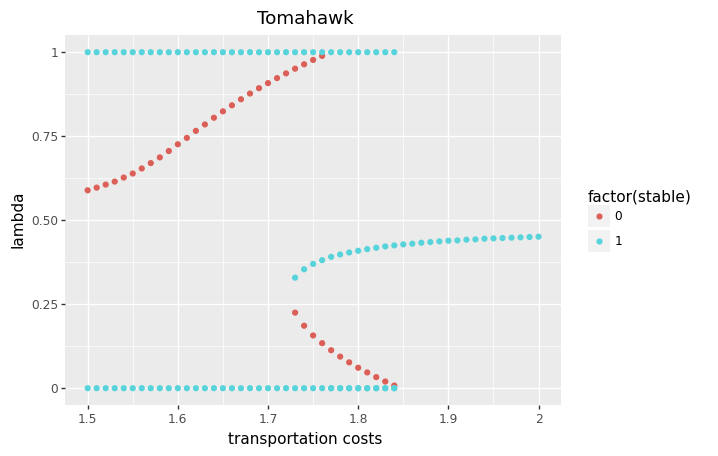

<ggplot: (8781451040928)>

In [8]:
(
ggplot(equilibria) + aes(x = 't_vec', y = 'lam_vec') + 
    geom_point(aes(colour = 'factor(stable)')) + 
    labs(title ="Tomahawk", y = "lambda", x = "transportation costs")
)

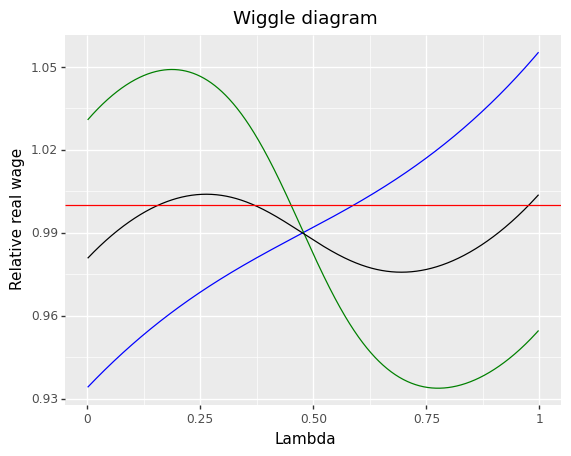

<ggplot: (8781454397883)>

In [19]:
(
ggplot(neg_data) + geom_line(data = top_line, mapping=aes(x = 'lamb', y = 'rel'), color='blue') + 
    geom_line(data = bottom_line, mapping=aes(x = 'lamb', y = 'rel'), color='green') + 
    geom_line(data = mid_line, mapping=aes(x = 'lamb', y = 'rel')) + geom_hline(yintercept = 1, colour = "red") +
    labs(title ="Wiggle diagram", y = "Relative real wage", x = 'Lambda', )
)

I hope this helps. 

Andrés Guzman Cordero.